# Automatic Program Optimization

## Prelude

In the past chapters, we learned about how to build primitive tensor functions and connect them to form end-to-end model executions. There are three primary types of abstractions we have used so far.

- A computational graph view that drives the high-level executions.
- Abstraction for primitive tensor functions.
- Library function calls via environment function registration.

All of these elements are encapsulated in an IRModule. Most of the MLC processes can be viewed as transformations among tensor functions.

There are many different ways to transform the same program. This chapter will discuss ways to automate some of the processes.

## Preparations

To begin with, we will import necessary dependencies and create helper functions.

In [1]:
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

In [2]:
import IPython


def code2html(code):
    """Helper function to use pygments to turn the code string into highlighted html."""
    import pygments
    from pygments.formatters import HtmlFormatter
    from pygments.lexers import Python3Lexer
    formatter = HtmlFormatter()
    html = pygments.highlight(code, Python3Lexer(), formatter)
    return "<style>%s</style>%s\n" % (formatter.get_style_defs(".highlight"), html)

## Recap:  Transform  a Primitive Tensor Function.

Let us begin by reviewing what we did in our previous chapters -- transforming a single primitive tensor function.

In [3]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def main(
        A: T.Buffer((128, 128), "float32"),
        B: T.Buffer((128, 128), "float32"),
        C: T.Buffer((128, 128), "float32"),
    ):
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for i, j, k in T.grid(128, 128, 128):
            with T.block("C"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    C[vi, vj] = 0.0
                C[vi, vj] = C[vi, vj] + A[vi, vk] * B[vk, vj]

First, let us define a set of inputs and outputs for evaluation.

In [4]:
dtype = "float32"
a_np = np.random.rand(128, 128).astype(dtype)
b_np = np.random.rand(128, 128).astype(dtype)
c_mm = a_np @ b_np

We can build and run `MyModule` as follows.

In [5]:
a_nd = tvm.nd.array(a_np)
b_nd = tvm.nd.array(b_np)
c_nd = tvm.nd.empty((128, 128), dtype="float32")

lib = tvm.build(MyModule, target="llvm")
f_timer_before = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule: %.3f ms" % (f_timer_before(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule: 1.751 ms


Next, we transform `MyModule` a bit by reorganizing the loop access pattern.

In [6]:
def schedule_mm(sch: tvm.tir.Schedule, jfactor=4):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    j_0, j_1 = sch.split(loop=j, factors=[None, jfactor])
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch

In [7]:
sch = tvm.tir.Schedule(MyModule)
sch = schedule_mm(sch)
IPython.display.HTML(code2html(sch.mod.script()))

Then we can build and run the re-organized program.

In [8]:
lib = tvm.build(sch.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule=>schedule_mm: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule=>schedule_mm: 0.420 ms


### Transformation Trace

Besides `sch.mod` field, another thing `tir.Schedule` offers is a trace  field that can be used to show the steps involved to get to the transformed module. We can print it out using the following code.

In [9]:
print(sch.trace)

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  l4, l5 = sch.split(loop=l2, factors=[None, 4], preserve_unit_iters=True, disable_predication=False)
  sch.reorder(l1, l4, l3, l5)
  b6 = sch.decompose_reduction(block=b0, loop=l3)


In [10]:
def schedule_mm(sch: tvm.tir.Schedule, jfactor=4):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    j_0, j_1 = sch.split(loop=j, factors=[None, jfactor])
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch

The above trace aligns with the transformations we specified in `schedule_mm`. One thing to note is that the trace (plus the original program) gives us a way to completely re-derive the final output program. Let us keep that in mind; we will use trace throughout this chapter as another way to inspect the transformations.

## Stochastic Schedule Transformation

Up until now, we have specified every detail about what transformations we want to make on the original TensorIR program. Many of those choices are based on our understanding of the underlying environment, such as cache and hardware unit. 

However, in practice, we may not be able to decide every detail accurately. Instead of doing so, we would like to specify **what are possible ways to transform the program, while leaving out some details**.

One natural way to achieve the goal is to add some stochastic (randomness) elements to our transformations. The following code does that.

In [11]:
def stochastic_schedule_mm(sch: tvm.tir.Schedule):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    j_factors = sch.sample_perfect_tile(loop=j, n=2)
    j_0, j_1 = sch.split(loop=j, factors=j_factors)
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch

![](../img/auto_prog_optim_stoch_sch_transformation.png)

Let us compare `stochastic_schedule_mm` and `schedule_mm` side by side. We can find that the only difference is how to specify `j_factors`. In the case of `schedule_mm`, `j_factors` is passed in as a parameter specified by us. In the case of `stochastic_schedule_mm`, it comes from `sch.sample_perfect_tile`.

As the name suggests, `sch.sample_perfect_tile` tries to draw random numbers to fill in `j_factors`. It samples factors such that they perfectly split the loop. For example, when the original loop size is `128`, possible ways to split the loop include: `[8, 16]`, `[32, 4]`, `[2, 64]` (note `8 * 16 = 32 * 4 = 2 * 64 = 128`). 

Let us first try to see what is the effect of `stochastic_schedule_mm` by running the following code-block. Try to run the following code block multiple times and observe the outcome difference. You might find that the loop bound of `j_1` changes each time we run the code-block.

In [12]:
sch = tvm.tir.Schedule(MyModule)
sch = stochastic_schedule_mm(sch)

IPython.display.HTML(code2html(sch.mod.script()))

What is happening here is that each time we run `stochastic_schedule_mm` it draws a  different `j_factors` randomly. We can print out the trace of the latest one to see the decisions we made in sampling.

In [13]:
print(sch.trace)

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[32, 4])
  l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True, disable_predication=False)
  sch.reorder(l1, l6, l3, l7)
  b8 = sch.decompose_reduction(block=b0, loop=l3)


When we look at the trace, pay close attention to the `decision=[...]` part of `sample_perfect_tile`. They correspond to the value that the `sampling_perfect_tile` picked in our last call to `stochastic_schedule_mm`.

As an alternative way to look at different samples of `stochastic_schedule_mm`, we can run the following block multiple times and look at the trace.

In [14]:
sch = tvm.tir.Schedule(MyModule)
sch = stochastic_schedule_mm(sch)
print(sch.trace)

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[8, 16])
  l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True, disable_predication=False)
  sch.reorder(l1, l6, l3, l7)
  b8 = sch.decompose_reduction(block=b0, loop=l3)


### Deep Dive into Stochastic Transformation

Now let us take a deeper dive into what happened in stochastic schedule transformations. We can find that it is a simple generalization of the original deterministic transformations, with two additional elements:

- Random variables that come from `sample_perfect_tile` and other sampling operations that we did not cover in the example.
- Schedule operations that take action depending on the random variables.

Let us try to run the stochastic transformation step by step.

In [15]:
sch = tvm.tir.Schedule(MyModule)
block_C = sch.get_block("C", "main")
i, j, k = sch.get_loops(block=block_C)
j_factors = sch.sample_perfect_tile(loop=j, n=2)

In [16]:
type(j_factors[0])

tvm.tir.expr.Var

Elements in the `j_factors` are not real integer numbers. Instead, they are **symbolic variables** that refer to a random variable being sampled. We can pass these variables to the transformation API to specify choices such as factor values.

In [17]:
print(sch.trace)

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[64, 2])


The schedule trace keeps track of the choices of these symbolic variables in the `decisions` field. So follow-up steps will be able to look up these choices to decide how to split the loop.

In [18]:
IPython.display.HTML(code2html(sch.mod.script()))

If we look at the code at the current time point, we can find that the module remains the same since we only sampled the random variables but have not yet made any transformation actions based on them.

Let us now take some of the actions:

In [19]:
j_0, j_1 = sch.split(loop=j, factors=j_factors)
sch.reorder(i, j_0, k, j_1)

These actions are recorded in the following trace.

In [20]:
print(sch.trace)

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[64, 2])
  l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True, disable_predication=False)
  sch.reorder(l1, l6, l3, l7)


If we retake a look at the code, the transformed module now corresponds to the updated versions after the actions are taken.

In [21]:
IPython.display.HTML(code2html(sch.mod.script()))

We can do some further transformations to get to the final state.

In [22]:
sch.reorder(i, j_0, k, j_1)
sch.decompose_reduction(block_C, k)

tir.BlockRV(0x19def360)

In [23]:
IPython.display.HTML(code2html(sch.mod.script()))

## Search Over Stochastic Transformations

One thing that you might realize is that `stochastic_schedule_mm` create a **search space of possible programs** depending on the specific decisions made at each sampling step.

![](../img/auto_prog_optim_transformation_search.png)

Coming back to our initial intuition, we want to be able to specify a set of **possible programs**  instead of one program. `stochastic_schedule_mm` did exactly that. Of course, one natural question to ask next is what is the best choice.

We will need a search algorithm to do that. To show what can be done here, let us first try the most straightforward search algorithm -- random search, in the following code block. It tries to run `stochastic_schedule_mm` repetitively, gets a transformed module, runs benchmark, then book keep the best one in history.

In [24]:
def random_search(mod: tvm.IRModule, num_trials=5):
    best_result = None
    best_sch = None

    for i in range(num_trials):
        sch = stochastic_schedule_mm(tvm.tir.Schedule(mod))
        lib = tvm.build(sch.mod, target="llvm")
        f_timer_after = lib.time_evaluator("main", tvm.cpu())
        result = f_timer_after(a_nd, b_nd, c_nd).mean

        print("=====Attempt %d, time-cost: %.3f ms====" % (i, result * 1000))
        print(sch.trace)

        # book keep the best result so far
        if best_result is None or result < best_result:
            best_result = result
            best_sch = sch

    return best_sch

sch = random_search(MyModule)

=====Attempt 0, time-cost: 0.495 ms====
# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[32, 4])
  l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True, disable_predication=False)
  sch.reorder(l1, l6, l3, l7)
  b8 = sch.decompose_reduction(block=b0, loop=l3)
=====Attempt 1, time-cost: 1.592 ms====
# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[128, 1])
  l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True, disable_predication=False)
  sch.reorder(l1, l6, l3, l7)
  b8 = sch.decompose_reduction(block=b0, loop=l3)
=====Attempt 2, time-cost: 0.438 ms====
# from tvm import tir
def

=====Attempt 4, time-cost: 1.437 ms====
# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[128, 1])
  l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True, disable_predication=False)
  sch.reorder(l1, l6, l3, l7)
  b8 = sch.decompose_reduction(block=b0, loop=l3)


If we run the code, we can find that it goes over a few choices and then returns the best run throughout five trials.

In [25]:
print(sch.trace)

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[16, 8])
  l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True, disable_predication=False)
  sch.reorder(l1, l6, l3, l7)
  b8 = sch.decompose_reduction(block=b0, loop=l3)


In practice, we use smarter algorithms. We also need to provide additional utilities, such as benchmarking on remote devices, if we are interested in optimization for other devices. TVM's meta schedule  API provides these additional capabilities.

`meta_schedule` is the namespace that comes to support search over a space of possible transformations. There are many additional things that meta-schedule do behind the scene:

- Parallel benchmarking across many processes.
- Use cost models to avoid benchmarking each time.
- Evolutionary search on the traces instead of randomly sampling at each time.

Despite these magics, the key idea remains the same: **use stochastic transformation to specify a search space of good programs, `tune_tir` API helps to search and find an optimized solution within the search space**.

In [26]:
from tvm import meta_schedule as ms

database = ms.tune_tir(
    mod=MyModule,
    target="llvm --num-cores=1",
    max_trials_global=64,
    num_trials_per_iter=64,
    space=ms.space_generator.ScheduleFn(stochastic_schedule_mm),
    work_dir="./tune_tmp",
)

sch = ms.tir_integration.compile_tir(database, MyModule, "llvm --num-cores=1")

2025-07-09 17:33:57 [INFO] Logging directory: ./tune_tmp/logs


2025-07-09 17:34:06 [INFO] LocalBuilder: max_workers = 10


2025-07-09 17:34:06 [INFO] LocalRunner: max_workers = 1


2025-07-09 17:34:06 [INFO] [task_scheduler.cc:159] Initializing Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,N/A,N/A,N/A,0,



Total trials: 0
Total latency (us): 0

2025-07-09 17:34:07 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |            N/A |          N/A |                   N/A |      0 |      
------------------------------------------------------------------------------------------------------
Total trials: 0
Total latency (us): 0



2025-07-09 17:34:07 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"


2025-07-09 17:34:07 [INFO] [task_scheduler.cc:193] Sending 5 sample(s) to builder


2025-07-09 17:34:08 [INFO] [task_scheduler.cc:195] Sending 5 sample(s) to runner


2025-07-09 17:34:10 [DEBUG] XGB iter   0: tr-p-rmse: 0.287230	tr-a-peak@32: 0.965617	tr-rmse: 0.319263	tr-rmse: 0.319263


2025-07-09 17:34:10 [DEBUG] XGB iter  25: tr-p-rmse: 0.082055	tr-a-peak@32: 1.000000	tr-rmse: 0.058679	tr-rmse: 0.058679


2025-07-09 17:34:10 [DEBUG] XGB iter  50: tr-p-rmse: 0.082454	tr-a-peak@32: 1.000000	tr-rmse: 0.058672	tr-rmse: 0.058672


2025-07-09 17:34:10 [DEBUG] XGB stopped. Best iteration: [21] tr-p-rmse:0.08169	tr-a-peak@32:1.00000	tr-rmse:0.05870	tr-rmse:0.05870 


2025-07-09 17:34:10 [INFO] [task_scheduler.cc:237] [Updated] Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,11.5128,364.3154,364.3154,5,


2025-07-09 17:34:10 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |        11.5128 |     364.3154 |              364.3154 |      5 |      
------------------------------------------------------------------------------------------------------
Total trials: 5
Total latency (us): 364.315


Total trials: 5
Total latency (us): 364.315



2025-07-09 17:34:10 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"


2025-07-09 17:34:11 [INFO] [task_scheduler.cc:193] Sending 0 sample(s) to builder


2025-07-09 17:34:11 [INFO] [task_scheduler.cc:195] Sending 0 sample(s) to runner


2025-07-09 17:34:11 [INFO] [task_scheduler.cc:237] [Updated] Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,11.5128,364.3154,364.3154,5,


2025-07-09 17:34:11 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |        11.5128 |     364.3154 |              364.3154 |      5 |      
------------------------------------------------------------------------------------------------------
Total trials: 5
Total latency (us): 364.315


Total trials: 5
Total latency (us): 364.315



2025-07-09 17:34:11 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"


2025-07-09 17:34:12 [INFO] [task_scheduler.cc:193] Sending 0 sample(s) to builder


2025-07-09 17:34:12 [INFO] [task_scheduler.cc:195] Sending 0 sample(s) to runner


2025-07-09 17:34:12 [INFO] [task_scheduler.cc:237] [Updated] Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,11.5128,364.3154,364.3154,5,


2025-07-09 17:34:12 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |        11.5128 |     364.3154 |              364.3154 |      5 |      
------------------------------------------------------------------------------------------------------
Total trials: 5
Total latency (us): 364.315


Total trials: 5
Total latency (us): 364.315



2025-07-09 17:34:12 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"


2025-07-09 17:34:13 [INFO] [task_scheduler.cc:193] Sending 0 sample(s) to builder


2025-07-09 17:34:13 [INFO] [task_scheduler.cc:195] Sending 0 sample(s) to runner


2025-07-09 17:34:13 [INFO] [task_scheduler.cc:237] [Updated] Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,11.5128,364.3154,364.3154,5,


2025-07-09 17:34:13 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |        11.5128 |     364.3154 |              364.3154 |      5 |      
------------------------------------------------------------------------------------------------------
Total trials: 5
Total latency (us): 364.315


Total trials: 5
Total latency (us): 364.315



2025-07-09 17:34:13 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"


2025-07-09 17:34:13 [INFO] [task_scheduler.cc:193] Sending 0 sample(s) to builder


2025-07-09 17:34:13 [INFO] [task_scheduler.cc:195] Sending 0 sample(s) to runner


2025-07-09 17:34:13 [INFO] [task_scheduler.cc:237] [Updated] Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,11.5128,364.3154,364.3154,5,


2025-07-09 17:34:13 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |        11.5128 |     364.3154 |              364.3154 |      5 |      
------------------------------------------------------------------------------------------------------
Total trials: 5
Total latency (us): 364.315


Total trials: 5
Total latency (us): 364.315



2025-07-09 17:34:13 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"


2025-07-09 17:34:14 [INFO] [task_scheduler.cc:260] Task #0 has finished. Remaining task(s): 0


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,11.5128,364.3154,364.3154,5,Y


2025-07-09 17:34:14 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |        11.5128 |     364.3154 |              364.3154 |      5 |    Y 
------------------------------------------------------------------------------------------------------
Total trials: 5
Total latency (us): 364.315


Total trials: 5
Total latency (us): 364.315



`tune_tir` functions return an optimized schedule found during the tuning process.

In [27]:
sch.trace.show()

In [28]:
IPython.display.HTML(code2html(sch.mod.script()))

In [29]:
lib = tvm.build(sch.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule after tuning: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule after tuning: 0.234 ms


### Leverage Default AutoScheduling

In the last section, we showed how to tune a workload with stochastic transformations that we crafted. Metaschedule comes with its own built-in set of generic stochastic transformations that works for a broad set of TensorIR computations. This approach is also called auto-scheduling, as the search space is generated by the system. We can run it by removing the line `space=ms.space_generator.ScheduleFn(stochastic_schedule_mm)`.

Under the hood, the meta-scheduler analyzes each block's data access and loop patterns and proposes stochastic transformations to the program. We won't go into these generic transformations in this chapter but want to note that they are also just stochastic transformations coupled with an analysis of the code. We can use the same mechanisms learned in the last section to enhance auto-scheduling. We will touch base on this topic in future chapters.

In [30]:
database = ms.tune_tir(
    mod=MyModule,
    target="llvm --num-cores=1",
    max_trials_global=64,
    num_trials_per_iter=64,
    work_dir="./tune_tmp",
)
sch = ms.tir_integration.compile_tir(database, MyModule, "llvm --num-cores=1")

2025-07-09 17:34:14 [INFO] Logging directory: ./tune_tmp/logs


2025-07-09 17:34:14 [INFO] LocalBuilder: max_workers = 10


2025-07-09 17:34:15 [INFO] LocalRunner: max_workers = 1


2025-07-09 17:34:15 [INFO] [task_scheduler.cc:159] Initializing Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,N/A,N/A,N/A,0,



Total trials: 0
Total latency (us): 0

2025-07-09 17:34:15 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |            N/A |          N/A |                   N/A |      0 |      
------------------------------------------------------------------------------------------------------
Total trials: 0
Total latency (us): 0



2025-07-09 17:34:15 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"


2025-07-09 17:34:17 [INFO] [task_scheduler.cc:193] Sending 63 sample(s) to builder


2025-07-09 17:34:32 [INFO] [task_scheduler.cc:195] Sending 63 sample(s) to runner


2025-07-09 17:34:46 [DEBUG] XGB iter   0: tr-p-rmse: 0.334921	tr-a-peak@32: 1.000000	tr-rmse: 0.310486	tr-rmse: 0.310486


2025-07-09 17:34:46 [DEBUG] XGB iter  25: tr-p-rmse: 0.036480	tr-a-peak@32: 1.000000	tr-rmse: 0.326815	tr-rmse: 0.326815


2025-07-09 17:34:47 [DEBUG] XGB iter  50: tr-p-rmse: 0.036500	tr-a-peak@32: 1.000000	tr-rmse: 0.326774	tr-rmse: 0.326774


2025-07-09 17:34:47 [DEBUG] XGB stopped. Best iteration: [20] tr-p-rmse:0.03633	tr-a-peak@32:1.00000	tr-rmse:0.32712	tr-rmse:0.32712 


2025-07-09 17:34:47 [INFO] [task_scheduler.cc:237] [Updated] Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,38.9506,107.6825,107.6825,63,


2025-07-09 17:34:47 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |        38.9506 |     107.6825 |              107.6825 |     63 |      
------------------------------------------------------------------------------------------------------
Total trials: 63
Total latency (us): 107.683




Total trials: 63
Total latency (us): 107.683

2025-07-09 17:34:47 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"


2025-07-09 17:34:49 [INFO] [task_scheduler.cc:193] Sending 1 sample(s) to builder


2025-07-09 17:34:51 [INFO] [task_scheduler.cc:195] Sending 1 sample(s) to runner


2025-07-09 17:34:51 [DEBUG] XGB validation: p-rmse: 0.297028	a-peak@32: 1.000000


2025-07-09 17:34:51 [INFO] [task_scheduler.cc:237] [Updated] Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,38.9506,107.6825,107.6825,64,


2025-07-09 17:34:51 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |        38.9506 |     107.6825 |              107.6825 |     64 |      
------------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 107.683


Total trials: 64
Total latency (us): 107.683



2025-07-09 17:34:51 [INFO] [task_scheduler.cc:260] Task #0 has finished. Remaining task(s): 0


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,38.9506,107.6825,107.6825,64,Y


2025-07-09 17:34:51 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |        38.9506 |     107.6825 |              107.6825 |     64 |    Y 
------------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 107.683


Total trials: 64
Total latency (us): 107.683



In [31]:
lib = tvm.build(sch.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule after tuning: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule after tuning: 0.101 ms


The result gets much faster than our original code. We can take a glimpse at the trace and the final code. For the purpose of this chapter, you do not need to understand all the transformations. At a high level, the trace involves:

- More levels of loop tiling transformations.
- Vectorization of intermediate computations.
- Parallelization and unrolling of loops.

In [32]:
sch.trace.show()

In [33]:
IPython.display.HTML(code2html(sch.mod.script()))

### Section Checkpoint

Let us have a checkpoint about what we have learned so far.

- Stochastic schedule allow us to express "what are the possible transformations".
- Metaschedule's `tune_tir` API helps to find a good solution within the space.
- Metaschedule comes with a default built-in set of stochastic transformations that covers a broad range of search space.

## Putting Things Back to End to End Model Execution

Up until now, we have learned to automate program optimization of a single tensor primitive function. How can we put it back and improve our end-to-end model execution?

From the MLC perspective, the automated search is a modular step, and we just need to replace the original primitive function implementation with the new one provided by the tuned result.

We will reuse the two-layer MLP example from the last chapter.

In [34]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

  0%|                                                                                                                                                             | 0.00/26.4M [00:00<?, ?B/s]

  0%|▏                                                                                                                                                    | 32.8k/26.4M [00:00<01:52, 234kB/s]

  0%|▎                                                                                                                                                    | 65.5k/26.4M [00:00<01:56, 226kB/s]

  0%|▌                                                                                                                                                    | 98.3k/26.4M [00:00<01:57, 224kB/s]

  1%|█▎                                                                                                                                                    | 229k/26.4M [00:00<00:53, 487kB/s]

  2%|██▍                                                                                                                                                   | 426k/26.4M [00:00<00:31, 824kB/s]

  3%|████▉                                                                                                                                                | 885k/26.4M [00:00<00:16, 1.56MB/s]

  7%|█████████▋                                                                                                                                          | 1.74M/26.4M [00:01<00:08, 3.03MB/s]

 13%|███████████████████▋                                                                                                                                | 3.51M/26.4M [00:01<00:03, 5.93MB/s]

 24%|███████████████████████████████████▌                                                                                                                | 6.36M/26.4M [00:01<00:02, 9.79MB/s]

 36%|█████████████████████████████████████████████████████▊                                                                                              | 9.60M/26.4M [00:01<00:01, 13.3MB/s]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                       | 13.7M/26.4M [00:01<00:00, 17.2MB/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 17.0M/26.4M [00:01<00:00, 18.4MB/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 20.2M/26.4M [00:01<00:00, 19.1MB/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 23.5M/26.4M [00:02<00:00, 19.8MB/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:02<00:00, 12.3MB/s]

  0%|                                                                                                                                                             | 0.00/29.5k [00:00<?, ?B/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 201kB/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 198kB/s]

  0%|                                                                                                                                                             | 0.00/4.42M [00:00<?, ?B/s]

  1%|█                                                                                                                                                    | 32.8k/4.42M [00:00<00:19, 224kB/s]

  1%|██▏                                                                                                                                                  | 65.5k/4.42M [00:00<00:19, 221kB/s]

  2%|███▎                                                                                                                                                 | 98.3k/4.42M [00:00<00:19, 220kB/s]

  4%|██████▋                                                                                                                                               | 197k/4.42M [00:00<00:10, 394kB/s]

  9%|█████████████▎                                                                                                                                        | 393k/4.42M [00:00<00:05, 725kB/s]

 18%|██████████████████████████▍                                                                                                                          | 786k/4.42M [00:00<00:02, 1.37MB/s]

 36%|████████████████████████████████████████████████████▋                                                                                               | 1.57M/4.42M [00:01<00:01, 2.64MB/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3.15M/4.42M [00:01<00:00, 5.14MB/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:01<00:00, 3.65MB/s]

  0%|                                                                                                                                                             | 0.00/5.15k [00:00<?, ?B/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 7.89MB/s]

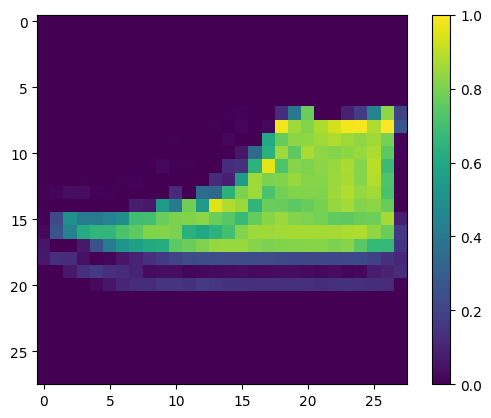

Class: Sneaker


In [35]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

We also download pre-packed model parameters that we will use in our examples.

In [36]:
# Hide outputs
!wget -nc https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2025-07-09 17:35:04--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 

140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... 

connected.


HTTP request sent, awaiting response... 

302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2025-07-09 17:35:06--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.


HTTP request sent, awaiting response... 

200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl’

          fasionmni   0%[                    ]       0  --.-KB/s               

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.1s    

2025-07-09 17:35:06 (3.30 MB/s) - ‘fasionmnist_mlp_params.pkl’ saved [407396/407396]



![](../img/e2e_fashionmnist_mlp_model.png)

As a reminder, the above figure shows the model of interest.

In [37]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))

data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

Let us use a mixture module where most of the components call into environment function and also come with one TensorIR function `linear0`.

In [38]:
@tvm.script.ir_module
class MyModuleMixture:
    @T.prim_func
    def linear0(X: T.Buffer((1, 784), "float32"),
                W: T.Buffer((128, 784), "float32"),
                B: T.Buffer((128,), "float32"),
                Z: T.Buffer((1, 128), "float32")):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, 784), "float32"),
             w0: R.Tensor((128, 784), "float32"),
             b0: R.Tensor((128,), "float32"),
             w1: R.Tensor((10, 128), "float32"),
             b1: R.Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_dps_packed("linear0", (x, w0, b0), R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_dps_packed("env.relu", (lv0,), R.Tensor((1, 128), dtype="float32"))
            out = R.call_dps_packed("env.linear", (lv1, w1, b1), R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

In [39]:
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def lnumpy_relu(x: tvm.nd.NDArray,
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

We can bind the parameters and see if it gives the correct prediction.

In [40]:
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)

In [41]:
ex = relax.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: Sneaker


The following code evaluates the run time cost of the module before the transformation. Note that because this is a small model, the number can fluctuate a bit between runs, so we just need to read the overall magnitude.

In [42]:
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=100)

print("MyModuleWithParams time-cost: %g ms" % (ftimer(data_nd).mean * 1000))

MyModuleWithParams time-cost: 0.132067 ms


We are now ready to tune the `linear0`. Our overall process is summarized in the following diagram.

![](../img/auto_prog_optim_optim_flow.png)

Currently, tune API only takes an IRModule with one `main` function, so we first get the `linear0` out into another module's main function and pass it to tune

In [43]:
mod_linear = tvm.IRModule.from_expr(MyModuleMixture["linear0"].with_attr("global_symbol", "main"))
IPython.display.HTML(code2html(mod_linear.script()))

In [44]:
database = ms.tune_tir(
    mod=mod_linear,
    target="llvm --num-cores=1",
    max_trials_global=64,
    num_trials_per_iter=64,
    work_dir="./tune_tmp",
)
sch = ms.tir_integration.compile_tir(database, mod_linear, "llvm --num-cores=1")

2025-07-09 17:35:06 [INFO] Logging directory: ./tune_tmp/logs


2025-07-09 17:35:06 [INFO] LocalBuilder: max_workers = 10


2025-07-09 17:35:07 [INFO] LocalRunner: max_workers = 1


2025-07-09 17:35:07 [INFO] [task_scheduler.cc:159] Initializing Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,200832,1,N/A,N/A,N/A,0,


2025-07-09 17:35:07 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
-----------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |            N/A |          N/A |                   N/A |      0 |      
-----------------------------------------------------------------------------------------------------
Total trials: 0
Total latency (us): 0


Total trials: 0
Total latency (us): 0



2025-07-09 17:35:07 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"


2025-07-09 17:35:10 [INFO] [task_scheduler.cc:193] Sending 64 sample(s) to builder


2025-07-09 17:35:24 [INFO] [task_scheduler.cc:195] Sending 64 sample(s) to runner


2025-07-09 17:35:40 [DEBUG] XGB iter   0: tr-p-rmse: 0.206534	tr-a-peak@32: 1.000000	tr-rmse: 0.349605	tr-rmse: 0.349605


2025-07-09 17:35:40 [DEBUG] XGB iter  25: tr-p-rmse: 0.036071	tr-a-peak@32: 0.999949	tr-rmse: 0.401057	tr-rmse: 0.401057


2025-07-09 17:35:40 [DEBUG] XGB iter  50: tr-p-rmse: 0.036071	tr-a-peak@32: 0.999949	tr-rmse: 0.401059	tr-rmse: 0.401059


2025-07-09 17:35:40 [DEBUG] XGB iter  75: tr-p-rmse: 0.036071	tr-a-peak@32: 0.999949	tr-rmse: 0.401059	tr-rmse: 0.401059


2025-07-09 17:35:40 [DEBUG] XGB stopped. Best iteration: [25] tr-p-rmse:0.03607	tr-a-peak@32:0.99995	tr-rmse:0.40106	tr-rmse:0.40106 


2025-07-09 17:35:40 [INFO] [task_scheduler.cc:237] [Updated] Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,200832,1,8.1771,24.5602,24.5602,64,


2025-07-09 17:35:40 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
-----------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |         8.1771 |      24.5602 |               24.5602 |     64 |      
-----------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 24.5602




Total trials: 64
Total latency (us): 24.5602

2025-07-09 17:35:40 [INFO] [task_scheduler.cc:260] Task #0 has finished. Remaining task(s): 0


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,200832,1,8.1771,24.5602,24.5602,64,Y


2025-07-09 17:35:40 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
-----------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |         8.1771 |      24.5602 |               24.5602 |     64 |    Y 
-----------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 24.5602


Total trials: 64
Total latency (us): 24.5602



Now we need to replace the original `linear0` with the new function after tuning. We can do that by first getting a `global_var`, a `pointer` reference to the functions inside the IRModule, then calling `update_func` to replace the function with the new one.

In [45]:
MyModuleWithParams2 = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
new_func = sch.mod["main"].with_attr("global_symbol", "linear0")
gv = MyModuleWithParams2.get_global_var("linear0")
MyModuleWithParams2.update_func(gv, new_func)
IPython.display.HTML(code2html(MyModuleWithParams2.script()))

We can find that the `linear0` has been replaced in the above code.

In [46]:
ex = relax.build(MyModuleWithParams2, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams2 Prediction:", class_names[pred_kind[0]])

MyModuleWithParams2 Prediction: Sneaker


Running the code again, we can find that we get an observable amount of time reduction, mainly thanks to the new `linear0` function.

In [47]:
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=50)

print("MyModuleWithParams2 time-cost: %g ms" % (ftimer(data_nd).mean * 1000))

MyModuleWithParams2 time-cost: 0.109471 ms


## Discussions

We might notice that our previous two chapters focused on **abstraction** while this chapter starts to focus on  **transformation**. Stochastic transformations specify what can be possibly optimized without nailing down all the choices. The meta-schedule API helps us to search over the space of possible transformations and pick the best one.

Importantly, putting the search result back into the end-to-end flow is just a matter of replacing the implementation of the original function with a new one that is informed by the tuning process. 

So we again are following the generic MLC process in the figure below. In future lectures, we will introduce more kinds of transformations on primitive functions and computational graph functions. A good MLC process composes these transformations together to form an end deployment form.

![](../img/mlc_process.png)

## Summary

- Stochastic transformations help us to specify a search space of possible programs.
- MetaSchedule searches over the search space and finds an optimized one.
- We can use another transformation to replace the primitive tensor function with optimized ones and an updated end-to-end execution flow.